## Eclipse Prediction

Use SkyField to find eclipses in a given time period, generate besellian elements and plot path of
selected eclipses

### General approach

As with all eclipse, brute force searching is required.

1. Find eclipse candidates by searching with coarse time interval
2. For each candidate, do a more precise evaluation
3. generate Besselians
4. For a give eclipse, plot the path using cartopy

### Finding Candidates for total/annular eclipse (first cut excludes partial/penumbral)

For the time interval selected, determinme whether the vector from sun through moon
intersects a plane through the centre of the earth. Becuase we want to do Besselian, we use that plane definition, which is:

> Definition: An imaginary plane passing through the center of the Earth, oriented perpendicular to the axis of the Moon's shadow (the line connecting the centers of the Sun and Moon) at a specific instant

The intersection of the SM vector with the plane is found by using the EM vector. fundamental plane normal vector from the centre of the earth is parallel to the actual shadow vector. We want just 1 component from that in the plane (the part perpendicular to the plane)

```
         ^ z_fp (Shadow Axis Direction; Normal to Fund. Plane)
          |
          |
          |                 M (Moon's Center)
          |                /.
          |               / .
          |              /  .
          |             /   .  <-- Shadow Axis Line (Parallel to z_fp)
          |            /    .
          |           /     .
          | m_vec    /      .
          |         /       .
          |        /        .
          |       /         .
  --------O------------------P_fp--------------------> y_fp (or x_fp) Axis
 (Earth's |      /          |                        (Fundamental Plane edge-on)
 Center)  |     /           | m_parallel
          |    /            | (Component || z_fp)
          |   /             |
          |  /              V
          | /               M_proj (Projection of M onto Fund. Plane)
          |/
          ------------------->
            m_perpendicular
            (Component in Fund. Plane)
            Vector O -> P_fp
```


In [39]:
# Setup Imports
import numpy as np
from skyfield.api import load, N, W, E, S, PlanetaryConstants # For units if needed
from skyfield import almanac
from skyfield.units import Angle
from scipy.optimize import minimize_scalar
from matplotlib import pyplot as plt

import datetime

# common variables an ephemeris etc
# Load ephemeris and timescale
ts = load.timescale()
# Using a more recent ephemeris like de440.bsp is generally recommended
try:
    eph = load('de440.bsp')
except Exception:
    print("Could not load de440.bsp, falling back to de421.bsp")
    eph = load('de421.bsp')

SUN_RADIUS_KM_HARDCODED = 695700.0
MOON_RADIUS_KM_HARDCODED = 1737.4
EARTH_EQUATORIAL_RADIUS_KM = 6378.137 # WGS84 value

# Define bodies from the ephemeris
sun = eph['sun']
moon = eph['moon']
earth = eph['earth']

In [40]:
# Core functions
def separation_angle(ts):
    """
    Determine if the angle between sun earth moon is small enough
    for the chance of eclipse

    Quick and dirty stasrting points

    """
    earth_pos = earth.at(ts)
    sun_pos = earth_pos.observe(sun).apparent()
    moon_pos = earth_pos.observe(moon).apparent()

    separation = sun_pos.separation_from(moon_pos)

    return separation.degrees

def eclipse_possible(ts):
    """
    Determine if the angle between sun earth moon is small enough
    for the chance of eclipse

    Quick and dirty stasrting points
    """

    return separation_angle(ts) < 3.0

# set default attributes for finding discrete events
eclipse_possible.step_days = 0.1

def find_plane_and_intersection(ts):
    """
    Returns a scalar representing distance
    """

    earth_pos = earth.at(ts)
    sun_gcrs = earth_pos.observe(sun) # Geometric position is fine here
    moon_gcrs = earth_pos.observe(moon)
    s_vec = sun_gcrs.position.km # Vector Earth->Sun [x,y,z] in GCRS (km)
    m_vec = moon_gcrs.position.km # Vector Earth->Moon [x,y,z] in GCRS (km)

    # Get Shadow axis vector
    L_vec = m_vec - s_vec
    z_fp = L_vec / np.linalg.norm(L_vec, axis=0) # Unit vector along shadow axis (Sun->Moon)
    # This is the Z-axis direction of our fundamental plane coordinate system

    # NCP vector in GCRS is approximately [0, 0, 1]
    NCP_vec = np.array([0.0, 0.0, 1.0])
    NCP_vec = NCP_vec[:, np.newaxis]

    # Project NCP onto the fundamental plane and normalize to get y_fp
    # Handle the case where z_fp is aligned with NCP (axis points poleward)
    # Correct way to calculate dot product for each time point
    dot_prod_z_ncp = np.sum(NCP_vec * z_fp, axis=0) # Result shape: (N,)

    # if abs(abs(dot_prod_z_ncp) - 1.0) < 1e-9: # Axis is aligned with NCP
    #     # Fundamental plane is the equator. Choose X along Vernal Equinox dir.
    #     # Need GCRS X-axis direction vector (approx [1, 0, 0])
    #     GCRS_X_vec = np.array([1.0, 0.0, 0.0])
    #     # Project GCRS X onto the plane (it's already in it if plane is equator)
    #     x_fp = GCRS_X_vec - np.dot(GCRS_X_vec, z_fp) * z_fp # Should be GCRS_X_vec itself
    #     x_fp /= np.linalg.norm(x_fp)
    #     y_fp = np.cross(z_fp, x_fp) # y = z x x gives correct orientation
    # else:
        # Standard case: Project NCP onto plane
        
    y_fp_unnormalized = NCP_vec - (dot_prod_z_ncp * z_fp)
    y_fp = y_fp_unnormalized / np.linalg.norm(y_fp_unnormalized)

    # Define X-axis (`x_fp`) using cross product for a right-handed system
    # Calculate cross product for each time point
    x_fp = np.cross(y_fp, z_fp, axisa=0, axisb=0).T # Transpose to get (3, N)

    return x_fp, y_fp, z_fp






12 minima found
2018-01-17 02:38  1.62 degrees separation
2018-02-15 20:51  1.11 degrees separation
2018-03-17 12:41  3.48 degrees separation
2018-04-16 01:43  4.83 degrees separation
2018-05-15 12:01  4.84 degrees separation
2018-06-13 20:09  3.57 degrees separation
2018-07-13 03:01  1.38 degrees separation
2018-08-11 09:46  1.17 degrees separation
2018-09-09 17:36  3.43 degrees separation
2018-10-09 03:32  4.80 degrees separation
2018-11-07 16:16  4.84 degrees separation
2018-12-07 07:52  3.46 degrees separation


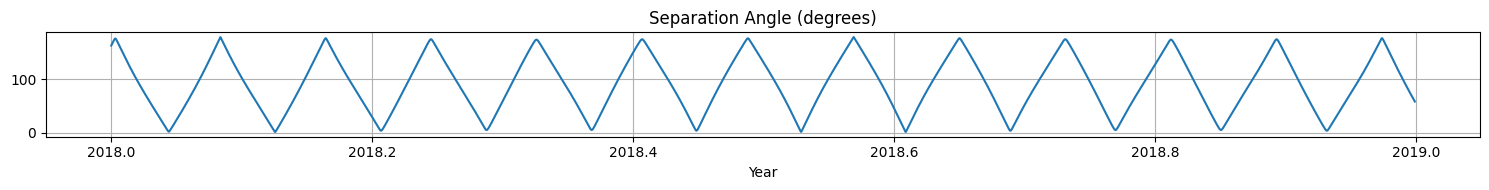

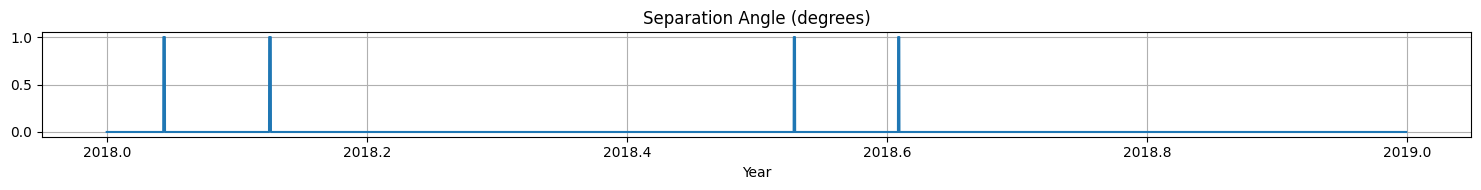

In [ ]:
# Test
# Define time range for search

#times, events = almanac.find_discrete(t_start, t_end, eclipse_possible)
from datetime import UTC, timedelta
from skyfield.searchlib import find_maxima, find_minima
fig, ax = plt.subplots(figsize=(15, 2))

start_time = datetime.datetime(2018,1,1,0,0,0, tzinfo=UTC)
total_hours = 365*24
datetime_list = [ start_time + timedelta(hours=i) for i in range(total_hours)]

t = ts.from_datetimes(datetime_list)
ax.plot(t.J, separation_angle(t))
ax.set(title='Separation Angle (degrees)', xlabel='Year')
ax.grid(True)

fig.tight_layout()
fig.savefig('separations.png')

fig2,ax2 = plt.subplots(figsize=(15, 2))
ax2.plot(t.J, eclipse_possible(t))
ax2.set(title='Separation Angle (degrees)', xlabel='Year')
ax2.grid(True)

fig2.tight_layout()
fig2.savefig('eclipse.png')


separation_angle.rough_period = 0.01
t, values = find_minima(min(t), max(t), separation_angle)

print(len(t), 'minima found')
for ti, vi in zip(t, values):
    print(ti.utc_strftime('%Y-%m-%d %H:%M '), '%.2f' % vi,
          'degrees separation')